# Časovne vrste

In [122]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


In [19]:
okuzeni = pd.read_csv("okuzeni.csv")
mestne_obcine = ['ljubljana', 'maribor', 'kranj', 'koper', 'celje', 'novo_mesto', 'velenje', 'nova_gorica', 'krško', 'ptuj', 'murska_sobota', 'slovenj_gradec']
okuzeni_obcine = okuzeni[mestne_obcine]
okuzeni_obcine["slovenj_gradec"].fillna(0, inplace=True)

okuzeni_obcine

C:\Users\tinem\AppData\Local\Temp\ipykernel_11168\3960100317.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  okuzeni_obcine["slovenj_gradec"].fillna(0, inplace=True)


ljubljana  maribor  kranj  koper  celje  novo_mesto  velenje  \
0         2953    860.0  924.0  232.0  433.0       362.0    429.0   
1         2913    937.0  907.0  207.0  383.0       352.0    445.0   
2         2762    939.0  837.0  188.0  378.0       371.0    414.0   
3         2645    960.0  790.0  193.0  369.0       370.0    435.0   
4         2532    969.0  735.0  197.0  365.0       383.0    430.0   
..         ...      ...    ...    ...    ...         ...      ...   
795       1203    379.0  342.0  269.0  137.0       196.0    159.0   
796       1154    370.0  340.0  252.0  134.0       194.0    159.0   
797       1130    368.0  345.0  254.0  134.0       193.0    160.0   
798       1111    351.0  359.0  260.0  129.0       201.0    169.0   
799        920    315.0  262.0  247.0  106.0       157.0    127.0   

     nova_gorica  krško   ptuj  murska_sobota  slovenj_gradec  
0          130.0  101.0  265.0          304.0           200.0  
1          138.0  102.0  266.0          289.0           192.0  
2          134.0  105.0  272.0          297.0           198.0  
3          142.0  111.0  297.0          309.0           192.0  
4          147.0  112.0  315.0          321.0           188.0  
..           ...    ...    ...            ...             ...  
795        127.0  172.0   79.0           73.0            54.0  
796        125.0  172.0   76.0           68.0            54.0  
797        124.0  162.0   77.0           65.0            54.0  
798        131.0  159.0   77.0           66.0            49.0  
799        108.0  125.0   56.0           56.0            34.0  

[800 rows x 12 columns]

## Modeli

In [21]:
data_len = len(okuzeni_obcine)
# število epohov
EPOCHS = 10 
# learning rate faktor
LR = 0.001
# število celic v notranji plasti nevronske mreže
HIDDEN = 32
# dolžina zaporedij dni, na katerih se model uči
SEQ_LEN = 14
# število napovednih dni
M = 7
# M = 30
# število dni za testno in učno množico
TEST_SIZE = 150
TRAIN_SIZE = data_len - TEST_SIZE

In [22]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data)-seq_length):
        sequences.append((data[i:i+seq_length], data[i+seq_length:i+seq_length+1]))
    return sequences


In [41]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.rnn(x.view(len(x), 1, -1))
        x = self.fc(x.view(len(x), -1))
        return x[-1]
    

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.gru(x.view(len(x), 1, -1))
        x = self.fc(x.view(len(x), -1))
        return x[-1]


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm(x.view(len(x), 1, -1))
        x = self.fc(x.view(len(x), -1))
        return x[-1]

In [25]:
def normiraj(sez, glavni_sez):
    if type(glavni_sez) == list:
        glavni_sez = torch.FloatTensor(glavni_sez)
    if type(sez) == list:
        sez = torch.FloatTensor(sez)
    return (sez - glavni_sez.mean())/max(glavni_sez.std(), 1)

def odnormiraj(sez, glavni_sez):
    return max(glavni_sez.std(), 1)*sez + glavni_sez.mean()

In [73]:
def fit_model(model, obcina, epochs = EPOCHS, lr = LR, hidden = HIDDEN, seq_len = SEQ_LEN, m = M, test_size = TEST_SIZE):
    y = torch.tensor(okuzeni_obcine[obcina]).float()
    train_data = y[:-test_size]
    test_data = y[-test_size:]
    train_sequences = create_sequences(train_data, seq_len)
    
    model = model
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    for epoch in range(epochs):
        for i, (seq, labels) in enumerate(train_sequences):
            optimizer.zero_grad()
            model.hidden = (torch.zeros(1,1,model.hidden_size))
            y_pred = model(normiraj(seq, seq))
            loss = criterion(y_pred, normiraj(labels,seq))
            loss.backward()
            optimizer.step()
            #if i%100 == 0:
            #    print(f'i: {i:03d}, Loss: {loss:.4f}')

    train_size = data_len - test_size
    test_inputs = y[-seq_len + train_size:].tolist()
    model = model.eval()
    predictions = []
    
    for i in range(test_size-m):
        j_test_inputs = test_inputs[i:seq_len+i]
        for j in range(m):
            j_seq_pre = torch.FloatTensor(j_test_inputs[-seq_len:])
            j_seq = normiraj(j_seq_pre, j_seq_pre)
            with torch.no_grad():
                model.hidden = (torch.zeros(1,1,model.hidden_size))
                j_pred = odnormiraj(model(j_seq).item(),j_seq_pre)
                j_test_inputs.append(j_pred.item())
        predictions.append([train_size + i, j_test_inputs[-m:], 0])
    return predictions


In [74]:
slovar_RNN_7 = {"napovedi": {}}
model = RNN(1, 32, 1)

for obcina in mestne_obcine:
        predicitons = fit_model(model, obcina, epochs = EPOCHS, lr = LR, hidden = HIDDEN, seq_len = SEQ_LEN, m = 7, test_size = TEST_SIZE)
        slovar_RNN_7["napovedi"][obcina] = predicitons

In [81]:
slovar_RNN_30 = {"napovedi": {}}
model = RNN(1, 32, 1)

for obcina in mestne_obcine:
        predicitons = fit_model(model, obcina, epochs = EPOCHS, lr = LR, hidden = HIDDEN, seq_len = SEQ_LEN, m = 30, test_size = TEST_SIZE)
        slovar_RNN_30["napovedi"][obcina] = predicitons

In [82]:
slovar_GRU_7 = {"napovedi": {}}
model = GRU(1, 32, 1)

for obcina in mestne_obcine:
        predicitons = fit_model(model, obcina, epochs = EPOCHS, lr = LR, hidden = HIDDEN, seq_len = SEQ_LEN, m = 7, test_size = TEST_SIZE)
        slovar_GRU_7["napovedi"][obcina] = predicitons

In [83]:
slovar_GRU_30 = {"napovedi": {}}
model = GRU(1, 32, 1)

for obcina in mestne_obcine:
        predicitons = fit_model(model, obcina, epochs = EPOCHS, lr = LR, hidden = HIDDEN, seq_len = SEQ_LEN, m = 30, test_size = TEST_SIZE)
        slovar_GRU_30["napovedi"][obcina] = predicitons

In [84]:
slovar_LSTM_7 = {"napovedi": {}}
model = LSTM(1, 32, 1)

for obcina in mestne_obcine:
        predicitons = fit_model(model, obcina, epochs = EPOCHS, lr = LR, hidden = HIDDEN, seq_len = SEQ_LEN, m = 7, test_size = TEST_SIZE)
        slovar_LSTM_7["napovedi"][obcina] = predicitons

In [85]:
slovar_LSTM_30 = {"napovedi": {}}
model = LSTM(1, 32, 1)

for obcina in mestne_obcine:
        predicitons = fit_model(model, obcina, epochs = EPOCHS, lr = LR, hidden = HIDDEN, seq_len = SEQ_LEN, m = 30, test_size = TEST_SIZE)
        slovar_LSTM_30["napovedi"][obcina] = predicitons

In [86]:
slovar_napovedi = {'RNN_7': slovar_RNN_7, 
                   'RNN_30': slovar_RNN_30,
                   'GRU_7': slovar_GRU_7,
                   'GRU_30': slovar_GRU_30,
                   'LSTM_7': slovar_LSTM_7,
                   'LSTM_30': slovar_LSTM_30}

slovar_napovedi

{'RNN_7': {'napovedi': {'ljubljana': [[650,
     [2712.111083984375,
      2726.976318359375,
      2739.94091796875,
      2761.7626953125,
      2794.75927734375,
      2829.35205078125,
      2866.599365234375],
     0],
    [651,
     [2660.669677734375,
      2651.741943359375,
      2656.45068359375,
      2669.25,
      2679.986328125,
      2693.638427734375,
      2714.085693359375],
     0],
    [652,
     [2686.35302734375,
      2702.548828125,
      2724.32177734375,
      2745.68359375,
      2771.9375,
      2805.052978515625,
      2842.16650390625],
     0],
    [653,
     [2666.2431640625,
      2676.144287109375,
      2688.305908203125,
      2703.78173828125,
      2724.380615234375,
      2749.1845703125,
      2776.228515625],
     0],
    [654,
     [2670.62939453125,
      2680.982177734375,
      2695.06396484375,
      2714.04736328125,
      2736.951416015625,
      2762.0712890625,
      2790.79638671875],
     0],
    [655,
     [2679.912353515625,
      2

## Analiza napovedi

In [87]:
y = okuzeni_obcine

In [88]:
slovar_RNN_7

{'napovedi': {'ljubljana': [[650,
    [2712.111083984375,
     2726.976318359375,
     2739.94091796875,
     2761.7626953125,
     2794.75927734375,
     2829.35205078125,
     2866.599365234375],
    0],
   [651,
    [2660.669677734375,
     2651.741943359375,
     2656.45068359375,
     2669.25,
     2679.986328125,
     2693.638427734375,
     2714.085693359375],
    0],
   [652,
    [2686.35302734375,
     2702.548828125,
     2724.32177734375,
     2745.68359375,
     2771.9375,
     2805.052978515625,
     2842.16650390625],
    0],
   [653,
    [2666.2431640625,
     2676.144287109375,
     2688.305908203125,
     2703.78173828125,
     2724.380615234375,
     2749.1845703125,
     2776.228515625],
    0],
   [654,
    [2670.62939453125,
     2680.982177734375,
     2695.06396484375,
     2714.04736328125,
     2736.951416015625,
     2762.0712890625,
     2790.79638671875],
    0],
   [655,
    [2679.912353515625,
     2693.64990234375,
     2712.3740234375,
     2734.97753906

In [89]:
slovar_napovedi.keys()

dict_keys(['RNN_7', 'RNN_30', 'GRU_7', 'GRU_30', 'LSTM_7', 'LSTM_30'])

In [100]:
def calculate_r2_obcina(data, obcina):
    r2_all_true = []
    r2_all_pred = []
    data2 = data["napovedi"]
    for i, predictions, loss in data2[obcina]:
        r2_all_true.append(y[obcina][i:i+len(predictions)])
        r2_all_pred.append(predictions)
    r2_all = r2_score(r2_all_true, r2_all_pred)
    return r2_all


In [107]:
r2_all = {}
for key in slovar_napovedi.keys():
    data = slovar_napovedi[key]
    r2_obcine = {}
    for obcina in mestne_obcine:
        r2_value = calculate_r2_obcina(data, obcina)
        r2_obcine[obcina] = r2_value
    
    r2_all[key] = {
        'r2_obcine': r2_obcine,
        'r2_average': sum(r2_obcine.values()) / len(r2_obcine)
    }

r2_all

{'RNN_7': {'r2_obcine': {'ljubljana': 0.9136359395514805,
   'maribor': 0.8658825509004436,
   'kranj': 0.6296381968026951,
   'koper': 0.3894732596325231,
   'celje': 0.66717567147937,
   'novo_mesto': 0.9271417062451207,
   'velenje': 0.8077052239257119,
   'nova_gorica': -1.2983864812727102,
   'krško': 0.6410239661441132,
   'ptuj': 0.7331776962103386,
   'murska_sobota': 0.8441412933144699,
   'slovenj_gradec': 0.4765225088828084},
  'r2_average': 0.5497609609846971},
 'RNN_30': {'r2_obcine': {'ljubljana': -3.233219522794231,
   'maribor': -2.8279201127503226,
   'kranj': 0.4245855327968086,
   'koper': -3.069309982640341,
   'celje': -0.2701470596113787,
   'novo_mesto': -1.6510974693833693,
   'velenje': -0.899826646023383,
   'nova_gorica': -0.5220254114333358,
   'krško': -16.411476918273372,
   'ptuj': -1.107695054075947,
   'murska_sobota': -6.458026860544944,
   'slovenj_gradec': -0.9397313431245815},
  'r2_average': -3.0804909039881996},
 'GRU_7': {'r2_obcine': {'ljubljana

In [114]:
#funkcija za risanje grafov
def prediction_graph(slovar, obcina, dan):
    my_dict = slovar
    napovedi = my_dict["napovedi"]
    actual_predictions = napovedi[obcina]
    napovedi_za_dan = []
    train_size = 800 - 150
    y = okuzeni_obcine[obcina]
    
    for i, predictions, loss in actual_predictions:
        napovedi_za_dan.append(predictions[dan-1])
    plt.title('Napoved za dan ' + str(dan) + ' za občino ' + obcina)
    plt.plot(torch.linspace(train_size,800,150),y[train_size:800])
    plt.plot(torch.linspace(train_size+dan-1,train_size+len(actual_predictions)+dan-1,len(actual_predictions)),pd.Series(napovedi_za_dan))
    plt.show()

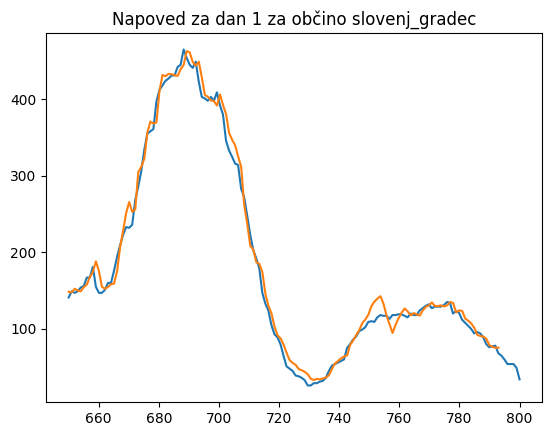

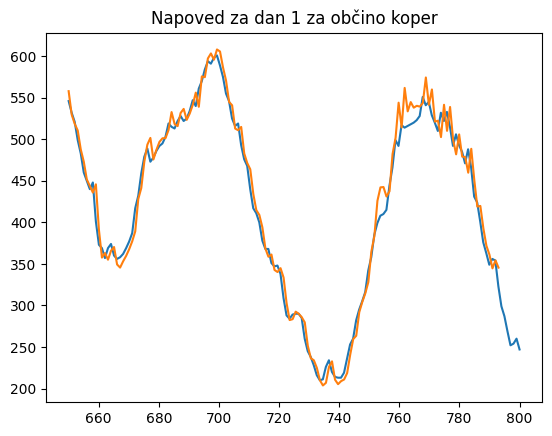

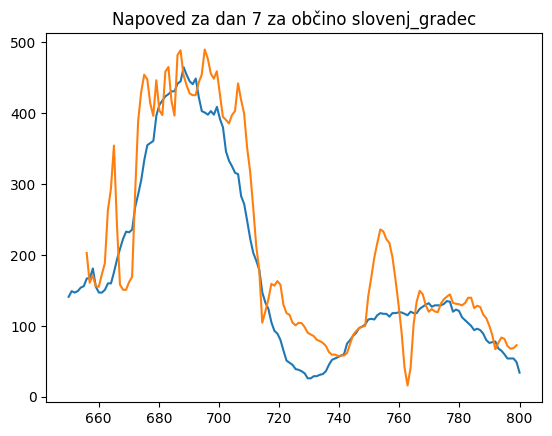

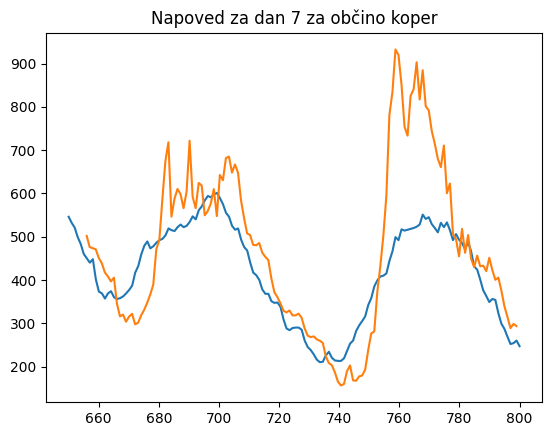

In [115]:
# najboljši model za 7 dni, najboljša in najslabša občina prvi in zadnji dan
for dan in [1, 7]:
    prediction_graph(slovar_LSTM_7, "slovenj_gradec", dan)
    prediction_graph(slovar_LSTM_7, "koper", dan)


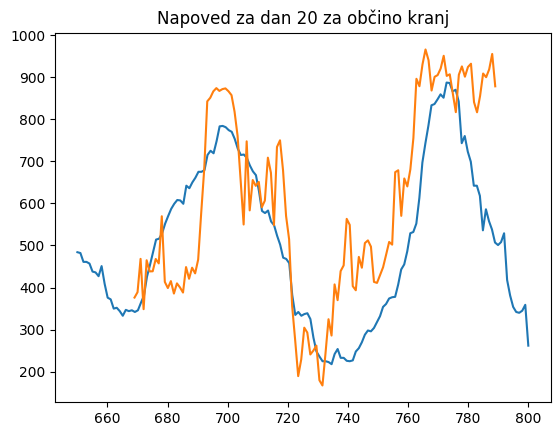

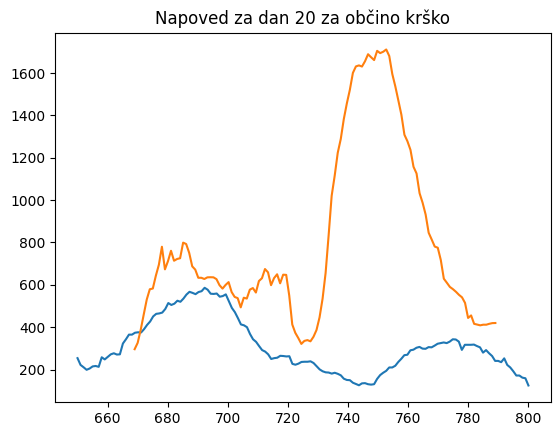

In [118]:
# najboljši model za 30 dni, najboljša in najslabša občina 20 dan
prediction_graph(slovar_RNN_30, "kranj", 20)
prediction_graph(slovar_RNN_30, "krško", 20)

In [119]:
def calculate_r2_day_obcina(dan, data, obcina):
    r2_all_true = []
    r2_all_pred = []
    data2 = data["napovedi"]
    for i, predictions, loss in data2[obcina]:
        r2_all_true.append(y[obcina][i+dan])
        r2_all_pred.append(predictions[dan])
    r2_all = r2_score(r2_all_true, r2_all_pred)
    return r2_all

def calculate_r2_for_days(slovar):
        data = slovar
        sez = []
        for dan in range(30): 
            r2_all = 0
            for obcina in mestne_obcine:
                r2_all += calculate_r2_day_obcina(dan, data, obcina)
            r2_all = r2_all/len(mestne_obcine)
            sez.append(r2_all)
        return sez

In [120]:
accuracy_days30 = calculate_r2_for_days(slovar_RNN_30)
accuracy_days30

[0.9809582365900408,
 0.929758843020998,
 0.836854894276598,
 0.6925503412252377,
 0.490153535012997,
 0.22553293718055203,
 -0.10775521008707285,
 -0.4951645404397449,
 -0.9000345869026822,
 -1.3114846557762154,
 -1.7340228967574893,
 -2.185265085094194,
 -2.6694504338842644,
 -3.1736168685949964,
 -3.6644336522081473,
 -4.1112884941129675,
 -4.48279709396326,
 -4.790710614531391,
 -5.034852466271941,
 -5.220843175392962,
 -5.38030887299021,
 -5.508296289146204,
 -5.610015879293969,
 -5.680447227036516,
 -5.725266580219365,
 -5.756318815898289,
 -5.774635322101169,
 -5.775402656942121,
 -5.7544416349016245,
 -5.723682854405653]

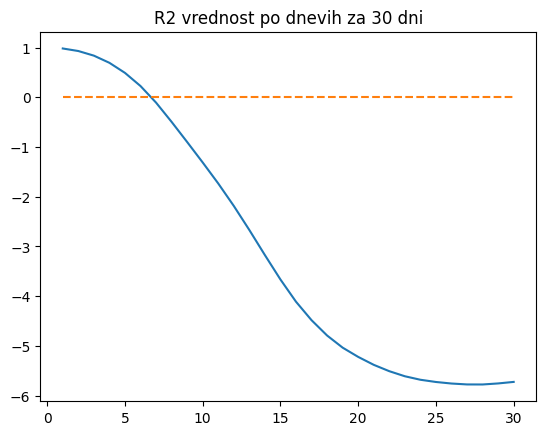

In [121]:
plt.title('R2 vrednost po dnevih za 30 dni')
plt.plot(torch.linspace(1,30,30),accuracy_days30)
plt.plot(torch.linspace(1,30,30), [0 for i in range(30)],linestyle='dashed')
plt.show()